# <center> **Data Preprocessing** </center>

## 0. Raw data summary

In [10]:
import os

RAW_DATA_DIR = "rawdata"  # Adjust this if your raw images are in a different folder

def summarize_raw_data():
    class_counts = {}

    for class_name in os.listdir(RAW_DATA_DIR):
        class_path = os.path.join(RAW_DATA_DIR, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg'))])
            class_counts[class_name] = num_images

    # Print summary
    print("\n📊 RAW DATASET SUMMARY:")
    total_images = sum(class_counts.values())
    for class_name, count in sorted(class_counts.items()):
        print(f" - {class_name}: {count} images")
    print(f"\n✅ Total Images: {total_images}")

summarize_raw_data()



📊 RAW DATASET SUMMARY:
 - 1_white: 92 images
 - 2_black: 92 images
 - 3_asian: 91 images
 - 4_latino: 91 images
 - 5_nativeamerican: 92 images
 - 6_middleeast: 90 images

✅ Total Images: 548



## 1. Convert all .jpeg to .jpg 

In [11]:
from PIL import Image
import os, cv2, csv

RAW_DATA_DIR = "rawdata"

def convert_to_jpg():
    for category in os.listdir(RAW_DATA_DIR):  # Loop through racial categories
        category_path = os.path.join(RAW_DATA_DIR, category)
        
        if not os.path.isdir(category_path):  # Skip files
            continue

        for filename in os.listdir(category_path):
            if filename.lower().endswith(".jpeg"):  # Only convert .jpeg
                file_path = os.path.join(category_path, filename)
                img = Image.open(file_path)
                new_filename = filename.replace(".jpeg", ".jpg")
                new_path = os.path.join(category_path, new_filename)
                
                img.convert("RGB").save(new_path, "JPEG")  # Convert and save
                os.remove(file_path)  # Delete the old .jpeg file
                print(f"Converted: {file_path} → {new_path}")

convert_to_jpg()


## 2.Crop faces

This aims to reduce background noise by focusing on facial features only

In [12]:
# Load OpenCV's Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define paths
RAW_DATA_DIR = "rawdata"  # Adjusted to match your structure
OUTPUT_DIR = "processed_faces"  # New folder for processed images

# Ensure output directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def detect_and_crop_faces():
    for category in os.listdir(RAW_DATA_DIR):  # Loop through racial categories
        input_folder = os.path.join(RAW_DATA_DIR, category)
        output_folder = os.path.join(OUTPUT_DIR, category)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        for filename in os.listdir(input_folder):
            if filename.endswith((".jpg", ".jpeg")):
                img_path = os.path.join(input_folder, filename)
                img = cv2.imread(img_path)

                if img is None:
                    print(f"Error loading image: {img_path}")
                    continue

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

                for i, (x, y, w, h) in enumerate(faces):
                    face = img[y:y+h, x:x+w]
                    face_resized = cv2.resize(face, (128, 128))  # Resize to 128x128
                    output_path = os.path.join(output_folder, f"{category}_{i}_{filename}")
                    cv2.imwrite(output_path, face_resized)
                    print(f"Saved: {output_path}")

detect_and_crop_faces()


Saved: processed_faces/4_latino/4_latino_0_istockphoto-1205724719-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1420793455-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1392528328-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1357723739-612x612 (1).jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1434640607-612x612.jpg
Saved: processed_faces/4_latino/4_latino_1_istockphoto-1434640607-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1181083533-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-939135324-640x640.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-825083304-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1184215364-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1607497623-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-1248195845-612x612.jpg
Saved: processed_faces/4_latino/4_latino_0_istockphoto-6894291

## 3.Labeling
Labeling data stored in their according folders

In [13]:
PROCESSED_DIR = "processed_faces"
LABELS_CSV = "labels.csv"

LABEL_MAP = {
    "white": 0,
    "black": 1,
    "asian": 2,
    "latino": 3,
    "nativeamerican": 4,
    "middleeast": 5
}

def clean_label(label):
    return "_".join(label.split("_")[1:])  # Removes number prefix

def create_labels_csv():
    with open(LABELS_CSV, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["filename", "label"])

        for category in os.listdir(PROCESSED_DIR):
            category_path = os.path.join(PROCESSED_DIR, category)

            if not os.path.isdir(category_path):
                continue

            cleaned_label = clean_label(category)
            numeric_label = LABEL_MAP.get(cleaned_label, -1)  # Convert to number

            for filename in os.listdir(category_path):
                writer.writerow([filename, numeric_label])

    print(f"Success! Labels CSV with numeric mapping: {LABELS_CSV}")

create_labels_csv()

Success! Labels CSV with numeric mapping: labels.csv


## 4.Split data into 80% train and 20% test

In [14]:
import os
import shutil
import random

PROCESSED_DIR = "processed_faces"
OUTPUT_DIR = "dataset"  # New directory for train/test split
TRAIN_RATIO = 0.8  # 80% training, 20% testing

def split_dataset():
    for category in os.listdir(PROCESSED_DIR):
        category_path = os.path.join(PROCESSED_DIR, category)

        if not os.path.isdir(category_path):
            continue

        images = os.listdir(category_path)
        random.shuffle(images)  # Shuffle for randomness

        split_idx = int(len(images) * TRAIN_RATIO)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        for split, split_images in [("train", train_images), ("test", test_images)]:
            split_folder = os.path.join(OUTPUT_DIR, split, category)
            os.makedirs(split_folder, exist_ok=True)

            for img in split_images:
                src_path = os.path.join(category_path, img)
                dest_path = os.path.join(split_folder, img)
                shutil.move(src_path, dest_path)

    print(f"Dataset split into {OUTPUT_DIR}/train and {OUTPUT_DIR}/test")

split_dataset()


Dataset split into dataset/train and dataset/test


# Summary

📊 Dataset Summary:

TRAIN SET:
  - 4_latino: 73 images
  - 6_middleeast: 72 images
  - 3_asian: 74 images
  - 1_white: 72 images
  - 2_black: 65 images
  - 5_nativeamerican: 68 images

TEST SET:
  - 4_latino: 19 images
  - 6_middleeast: 18 images
  - 3_asian: 19 images
  - 1_white: 19 images
  - 2_black: 17 images
  - 5_nativeamerican: 17 images

🔹 Total Images: 533


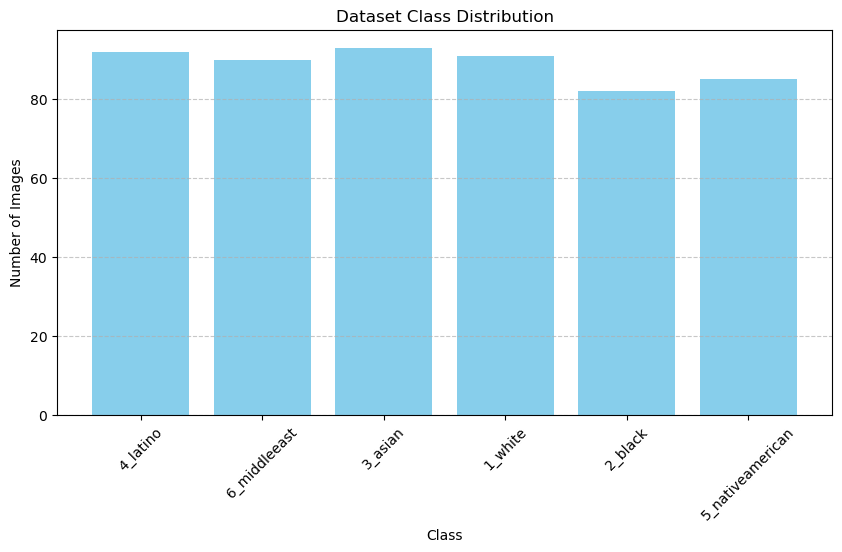

In [15]:
import matplotlib.pyplot as plt
import os
from collections import Counter

DATASET_DIR = "dataset"  # The folder containing train/test splits

def dataset_summary():
    summary = {}
    total_images = 0

    for split in ["train", "test"]:
        split_path = os.path.join(DATASET_DIR, split)
        class_counts = {}

        if not os.path.exists(split_path):
            continue  # Skip if folder doesn't exist

        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                class_counts[class_name] = num_images
                total_images += num_images

        summary[split] = class_counts

    # Print summary
    print("📊 Dataset Summary:")
    for split, class_counts in summary.items():
        print(f"\n{split.upper()} SET:")
        for class_name, count in class_counts.items():
            print(f"  - {class_name}: {count} images")

    print(f"\n🔹 Total Images: {total_images}")


def plot_class_distribution():
    class_counts = {}

    for split in ["train", "test"]:
        split_path = os.path.join(DATASET_DIR, split)
        if not os.path.exists(split_path):
            continue

        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                if class_name not in class_counts:
                    class_counts[class_name] = 0
                class_counts[class_name] += num_images

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Dataset Class Distribution")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

dataset_summary()

plot_class_distribution()
